In [24]:
# Gerekli kutuphaneleri ice aktar
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import sklearn_crfsuite
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from seqeval.metrics import classification_report, f1_score
from IPython.core.display import display, HTML


In [25]:
# Dataseti yukle ve oku
def load_conll_data(filepath):
    sentences = []
    sentence = []
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("-DOCSTART-"):
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                parts = line.split()
                if len(parts) >= 2:
                    token = parts[0]
                    label = parts[-1]
                    sentence.append((token, label))
        if sentence:
            sentences.append(sentence)
    return sentences


data = load_conll_data("veriseti.conll")
print(f"Toplam cümle sayısı: {len(data)}")
print(f"Örnek cümle: {data[0]}")


Toplam cümle sayısı: 38
Örnek cümle: [('Microsoft', 'B-ORG'), ('Türkiye', 'B-COUNTRY'), ("'den", 'O'), ('35', 'B-AGE'), ('yaşındaki', 'I-AGE'), ('yazılım', 'B-PROFESSION'), ('mühendisi', 'I-PROFESSION'), ('Ahmet', 'B-PERSON'), ('Bey', 'I-PERSON'), ('İstanbul', 'B-CITY'), ("'a", 'O'), ('taşındı', 'O'), ('.', 'O')]


In [26]:
# Kelimeler icin ozellik fonksiyonlarini cikar
def word2features(sent, i):
    word = sent[i][0]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]


In [27]:
#CRF modelini egitimi ve degerlendirme fonksiyonu
def train_and_evaluate(data):
    X = [sent2features(s) for s in data]
    y = [sent2labels(s) for s in data]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )
    crf.fit(X_train, y_train)
    y_pred = crf.predict(X_test)

    print("\n--- CLASSIFICATION REPORT ---\n")
    print(classification_report(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))


    tokens = [f['word.lower()'] for f in X_test[5]]
    labels = y_test[5]
    generate_annotated_html(tokens, labels)

    return y_test, y_pred, y_train


In [28]:
#Annotated HTML Gosterimi
def generate_annotated_html(tokens, labels, filename="annotated_text.html"):
    entity_colors = {
        "PERSON": "#F48FB1",
        "CITY": "#A5D6A7",
        "PROFESSION": "#FFB74D",
        "EMAIL": "#F8BBD0",
        "STREET": "#B0BEC5",
        "PHONE": "#90CAF9",
        "AGE": "#4DD0E1",
        "ORG": "#80CBC4",
        "URL": "#CE93D8",
        "COUNTRY": "#AED581",
        "DATE": "#81D4FA",
        "STATE": "#E6EE9C",
        "ZIP": "#FFD54F",
    }

    html = "<html><body><div style='font-family:monospace; line-height:2;'>"

    # Kelime ve etiketleri grup olarak yakala
    current_label = None
    current_chunk = []

    def flush_chunk():
        nonlocal current_chunk, current_label, html
        if current_chunk:
            chunk_text = " ".join(current_chunk)
            color = entity_colors.get(current_label, "#E0E0E0")
            html += f"<span style='background-color:{color}; padding:6px; margin:2px; border-radius:6px; display:inline-block;'>{chunk_text} <small><strong>{current_label}</strong></small></span> "
            current_chunk = []
            current_label = None

    for token, label in zip(tokens, labels):
        if label == "O":
            flush_chunk()
            html += token + " "
        else:
            label_type = label.split("-")[-1]
            if label_type != current_label:
                flush_chunk()
                current_label = label_type
            current_chunk.append(token)

    flush_chunk()
    html += "</div></body></html>"

    with open(filename, "w", encoding="utf-8") as f:
        f.write(html)

    display(HTML(html))


In [36]:
#Confusion Matrix gorsellestir
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred):
    """
    Test ve tahmin edilen etiketleri kullanarak confusion matrix görselleştirir.
    """
    true_labels = sum(y_test, [])
    pred_labels = sum(y_pred, [])
    labels = sorted(set(true_labels + pred_labels))

    cm = confusion_matrix(true_labels, pred_labels, labels=labels)

    plt.figure(figsize=(18, 14))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel("Tahmin Edilen Etiketler")
    plt.ylabel("Gerçek Etiketler")
    plt.title("CRF Modeli – Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [37]:
#etiket dagilimi yap
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def plot_label_distribution(y_train, threshold=0.05):

    # 'O' etiketi disindaki tum etiketleri al
    all_labels = [label for sentence in y_train for label in sentence if label != "O"]
    label_counts = Counter(all_labels)

    total = sum(label_counts.values())
    label_percent = {k: v / total for k, v in label_counts.items()}

    filtered_counts = {}
    other_sum = 0
    for label, count in label_counts.items():
        if label_percent[label] < threshold:
            other_sum += count
        else:
            filtered_counts[label] = count
    if other_sum > 0:
        filtered_counts['Diğer'] = other_sum

    df = pd.DataFrame(filtered_counts.items(), columns=["Entity", "Count"]).sort_values(by="Count", ascending=False)

    # Pie chart
    plt.figure(figsize=(10,8))
    explode = [0.05 if entity != 'Diğer' else 0 for entity in df['Entity']]
    plt.pie(df['Count'], labels=df['Entity'], autopct='%1.1f%%', startangle=140,
            labeldistance=1.1, pctdistance=0.8, explode=explode, textprops={'fontsize': 10})
    plt.title("Entity Dağılımı – Pie Chart", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Bar chart
    plt.figure(figsize=(12,8))
    sns.barplot(x='Count', y='Entity', data=df.sort_values('Count', ascending=True))
    plt.title("Entity Dağılımı – Bar Chart", fontsize=14)
    plt.xlabel("Örnek Sayısı")
    plt.ylabel("Entity")
    plt.tight_layout()
    plt.show()


In [38]:
#Annotated text
from IPython.core.display import display, HTML

def generate_annotated_html(tokens, labels, filename="annotated_text.html"):
    """
    Token ve etiket listesi alır, etiketlere göre renkli vurgulama yapar ve HTML olarak gösterir.
    """
    entity_colors = {
        "PERSON": "#F48FB1",
        "CITY": "#A5D6A7",
        "PROFESSION": "#FFB74D",
        "EMAIL": "#F8BBD0",
        "STREET": "#B0BEC5",
        "PHONE": "#90CAF9",
        "AGE": "#4DD0E1",
        "ORG": "#80CBC4",
        "URL": "#CE93D8",
        "COUNTRY": "#AED581",
        "DATE": "#81D4FA",
        "STATE": "#E6EE9C",
        "ZIP": "#FFD54F",
    }

    html = "<html><body><div style='font-family:monospace; line-height:2;'>"

    current_label = None
    current_chunk = []

    def flush_chunk():
        nonlocal current_chunk, current_label, html
        if current_chunk:
            chunk_text = " ".join(current_chunk)
            color = entity_colors.get(current_label, "#E0E0E0")
            html += f"<span style='background-color:{color}; padding:6px; margin:2px; border-radius:6px; display:inline-block;'>{chunk_text} <small><strong>{current_label}</strong></small></span> "
            current_chunk = []
            current_label = None

    for token, label in zip(tokens, labels):
        if label == "O":
            flush_chunk()
            html += token + " "
        else:
            label_type = label.split("-")[-1]
            if label_type != current_label:
                flush_chunk()
                current_label = label_type
            current_chunk.append(token)

    flush_chunk()
    html += "</div></body></html>"

    with open(filename, "w", encoding="utf-8") as f:
        f.write(html)

    display(HTML(html))



--- CLASSIFICATION REPORT ---

              precision    recall  f1-score   support

         AGE       1.00      0.75      0.86         4
        CITY       1.00      0.83      0.91         6
     COUNTRY       0.80      1.00      0.89         4
        DATE       1.00      0.75      0.86         4
         ORG       1.00      0.50      0.67         4
      PERSON       1.00      0.67      0.80         3
  PROFESSION       1.00      0.33      0.50         9
       STATE       1.00      1.00      1.00         1
      STREET       1.00      1.00      1.00         1
         URL       0.00      0.00      0.00         1
         ZIP       1.00      1.00      1.00         1

   micro avg       0.96      0.66      0.78        38
   macro avg       0.89      0.71      0.77        38
weighted avg       0.95      0.66      0.75        38

F1-score: 0.78125


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


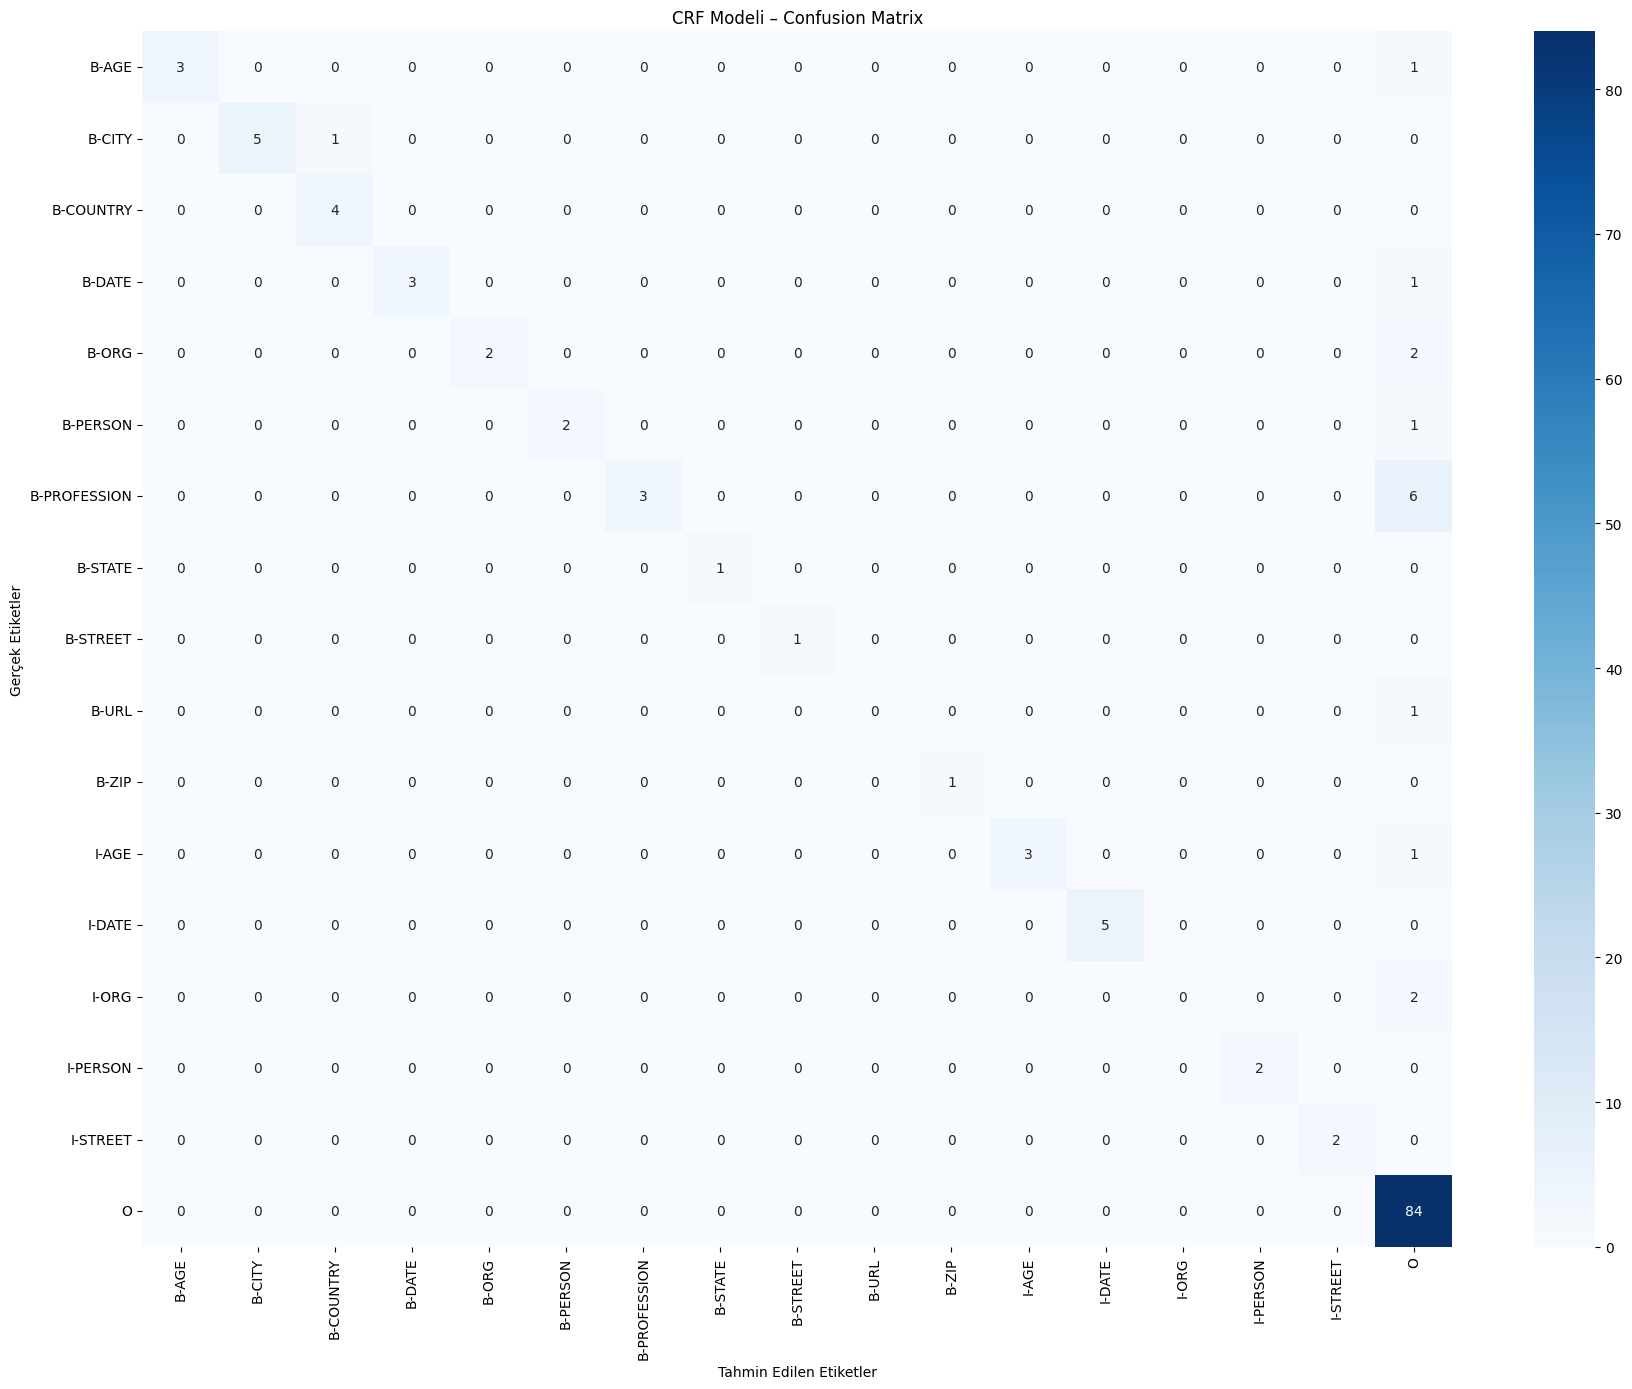

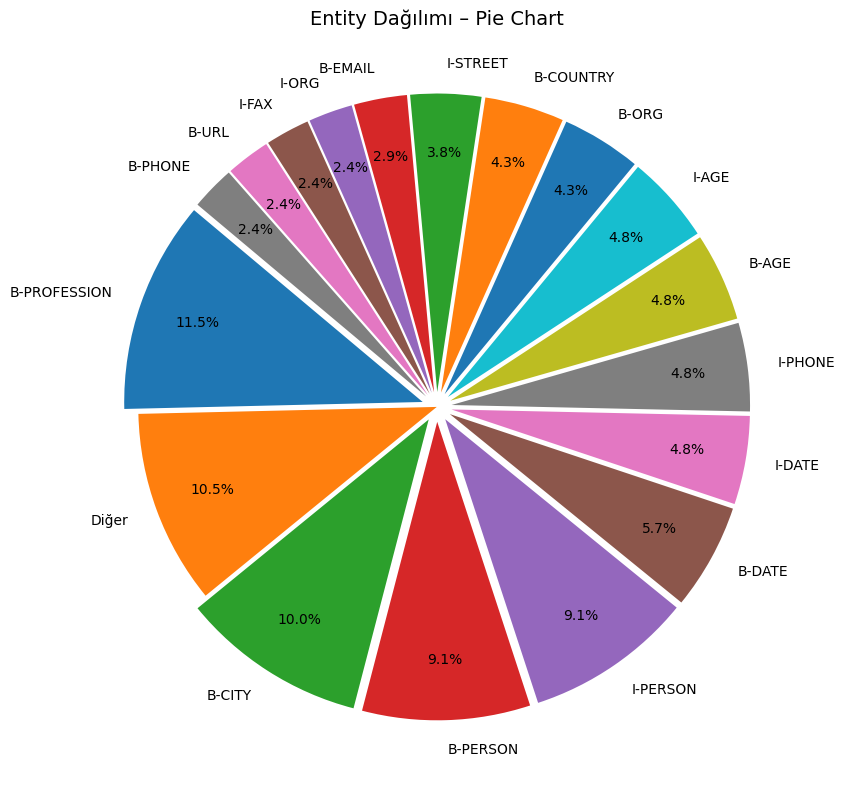

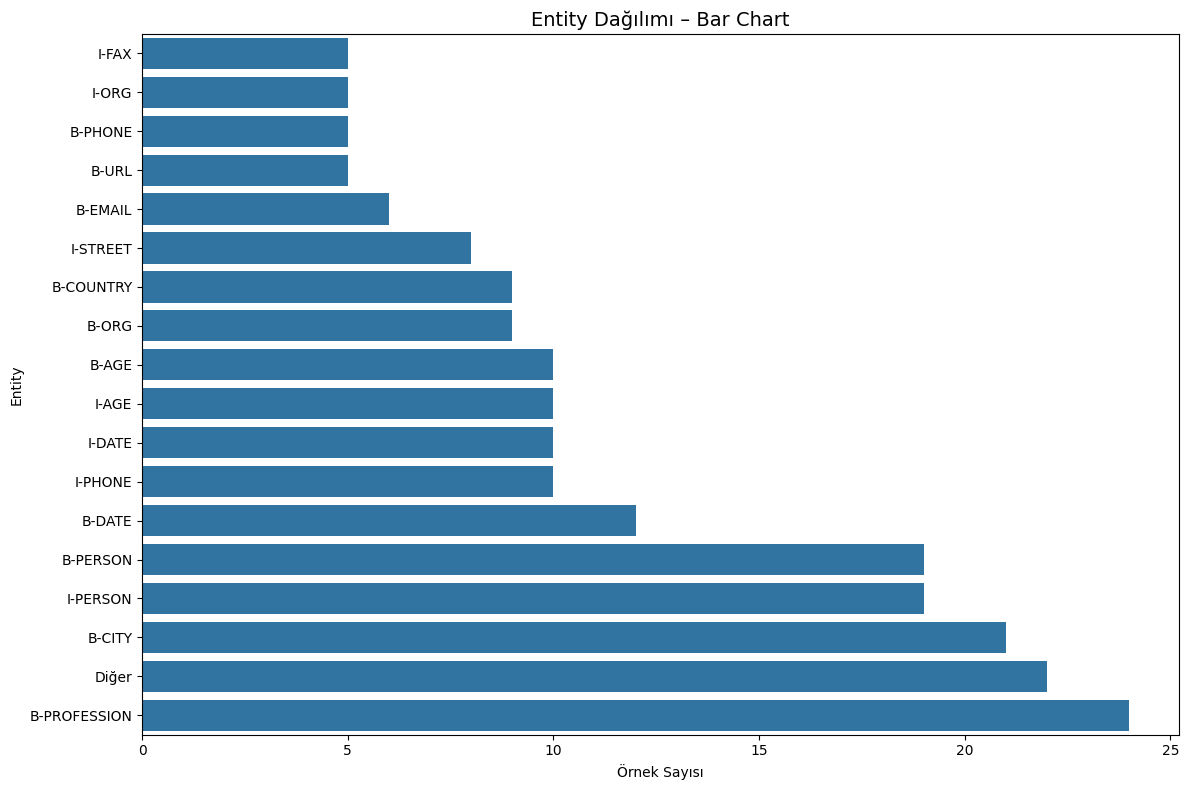

In [39]:
def run_full_visualization_pipeline(data_path="veriseti.conll"):
    # Veriyi oku
    data = load_conll_data(data_path)

    # Modeli egit ve test et
    y_test, y_pred, y_train = train_and_evaluate(data)

    # Confusion matrix ciz
    plot_confusion_matrix(y_test, y_pred)

    # Etiket dagilimini çiz (yuzde 2 altindakileri 'diger' olarak grupla)
    plot_label_distribution(y_train, threshold=0.02)

    # Annotated HTML gosterimi icin ornek cumle
    tokens = [token.lower() for token, label in data[5]]
    labels = y_test[5]
    generate_annotated_html(tokens, labels)

# Fonksiyonu cagir
run_full_visualization_pipeline()
